# Predicting Job Automation Risk with Multilayer Perceptrons (MLPs)

In this tutorial-style notebook, we use a Multilayer Perceptron (MLP) to predict the **job automation risk category** by 2030 using the `AI_Impact_on_Jobs_2030` dataset.

We will:
- Explore the dataset with visualisations.
- Build a preprocessing pipeline for numeric + categorical features.
- Train a baseline MLP classifier for `Risk_Category`.
- Systematically vary **depth** and **width** of the MLP and measure performance.
- Train a tuned MLP and evaluate it.
- Use multiple graphs: heatmaps, confusion matrices, learning curve, PCA plot.


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    learning_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

print('Libraries imported.')

Libraries imported.


In [8]:
file_path = '/content/drive/MyDrive/AI_Impact_on_Jobs_2030.csv'  # change if needed
df = pd.read_csv(file_path)

print('Shape:', df.shape)
df.head()

Shape: (3000, 18)


,Job_Title,Average_Salary,Years_Experience,Education_Level,AI_Exposure_Index,Tech_Growth_Factor,Automation_Probability_2030,Risk_Category,Skill_1,Skill_2,Skill_3,Skill_4,Skill_5,Skill_6,Skill_7,Skill_8,Skill_9,Skill_10
0,Security Guard,45795,28,Master's,0.18,1.28,0.85,High,0.45,0.10,0.46,0.33,0.14,0.65,0.06,0.72,0.94,0.00
1,Research Scientist,133355,20,PhD,0.62,1.11,0.05,Low,0.02,0.52,0.40,0.05,0.97,0.23,0.09,0.62,0.38,0.98
2,Construction Worker,146216,2,High School,0.86,1.18,0.81,High,0.01,0.94,0.56,0.39,0.02,0.23,0.24,0.68,0.61,0.83
3,Software Engineer,136530,13,PhD,0.39,0.68,0.60,Medium,0.43,0.21,0.57,0.03,0.84,0.45,0.40,0.93,0.73,0.33
4,Financial Analyst,70397,22,High School,0.52,1.46,0.64,Medium,0.75,0.54,0.59,0.97,0.61,0.28,0.30,0.17,0.02,0.42


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Job_Title                    3000 non-null   object 
 1   Average_Salary               3000 non-null   int64  
 2   Years_Experience             3000 non-null   int64  
 3   Education_Level              3000 non-null   object 
 4   AI_Exposure_Index            3000 non-null   float64
 5   Tech_Growth_Factor           3000 non-null   float64
 6   Automation_Probability_2030  3000 non-null   float64
 7   Risk_Category                3000 non-null   object 
 8   Skill_1                      3000 non-null   float64
 9   Skill_2                      3000 non-null   float64
 10  Skill_3                      3000 non-null   float64
 11  Skill_4                      3000 non-null   float64
 12  Skill_5                      3000 non-null   float64
 13  Skill_6           

Risk_Category
High       740
Low        739
Medium    1521
Name: count, dtype: int64


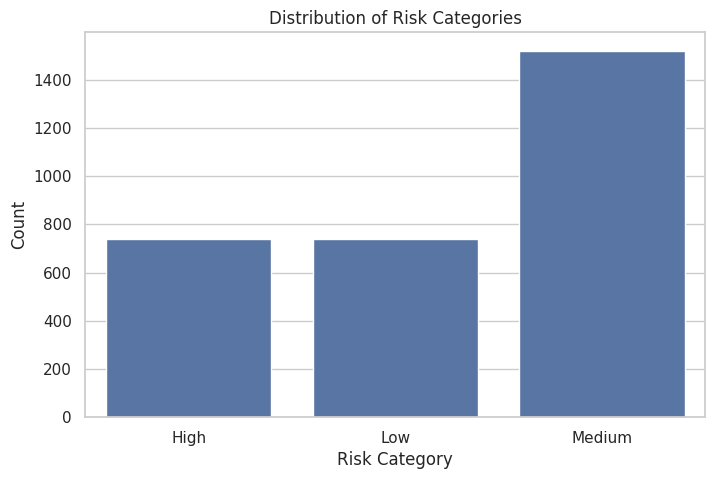

In [10]:
risk_counts = df['Risk_Category'].value_counts().sort_index()
print(risk_counts)

plt.figure()
sns.barplot(x=risk_counts.index, y=risk_counts.values)
plt.title('Distribution of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.show()

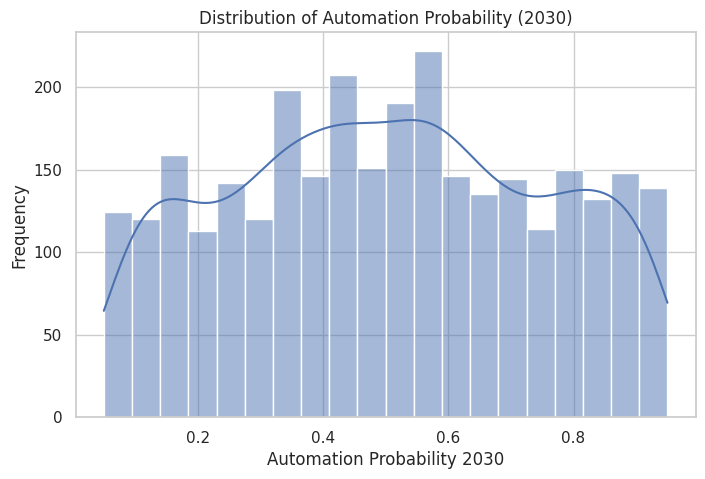

In [11]:
plt.figure()
sns.histplot(df['Automation_Probability_2030'], bins=20, kde=True)
plt.title('Distribution of Automation Probability (2030)')
plt.xlabel('Automation Probability 2030')
plt.ylabel('Frequency')
plt.show()

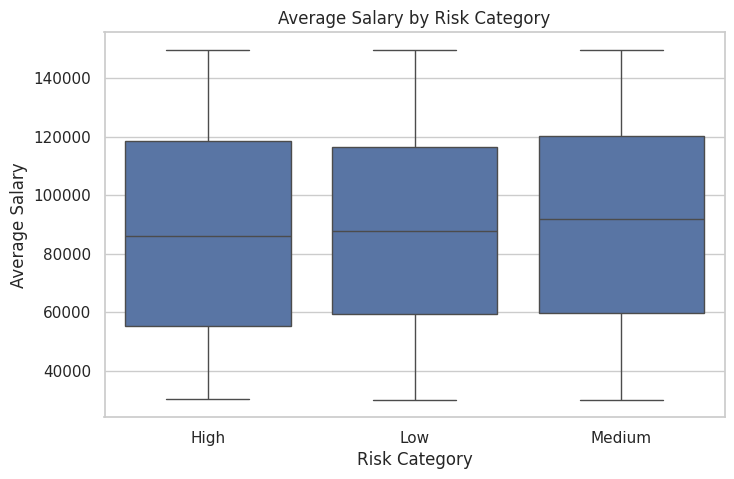

In [12]:
plt.figure()
sns.boxplot(data=df, x='Risk_Category', y='Average_Salary')
plt.title('Average Salary by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Average Salary')
plt.show()

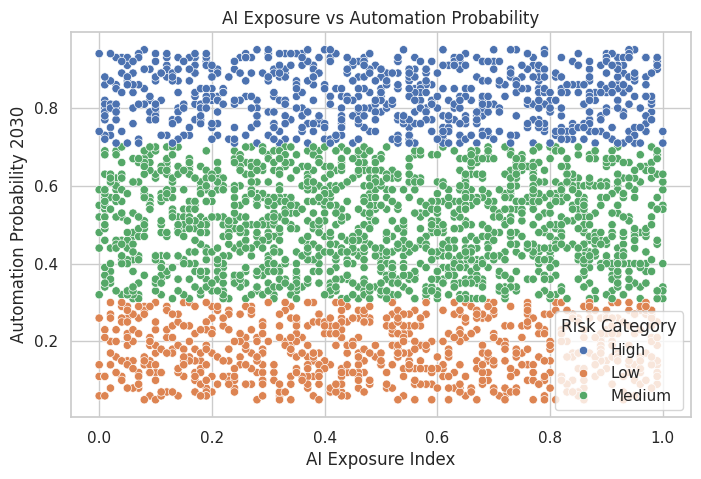

In [13]:
plt.figure()
sns.scatterplot(
    data=df,
    x='AI_Exposure_Index',
    y='Automation_Probability_2030',
    hue='Risk_Category'
)
plt.title('AI Exposure vs Automation Probability')
plt.xlabel('AI Exposure Index')
plt.ylabel('Automation Probability 2030')
plt.legend(title='Risk Category')
plt.show()

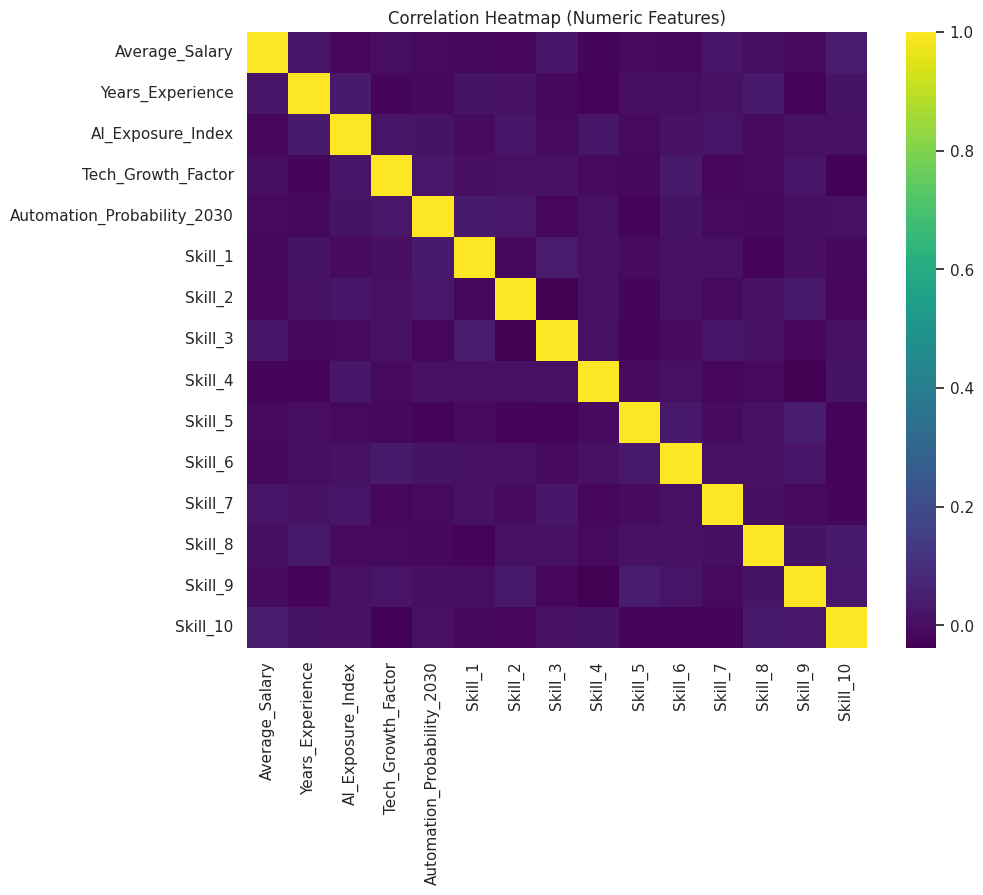

In [14]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

In [15]:
target_col = 'Risk_Category'

feature_cols = [
    'Average_Salary', 'Years_Experience',
    'AI_Exposure_Index', 'Tech_Growth_Factor',
    'Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5',
    'Skill_6', 'Skill_7', 'Skill_8', 'Skill_9', 'Skill_10',
    'Education_Level'
]

X = df[feature_cols].copy()
y = df[target_col].copy()

categorical_features = ['Education_Level']
numeric_features = [col for col in feature_cols if col not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (2400, 15)
Test shape: (600, 15)


In [16]:
# Use sparse_output=False (or sparse=False on older sklearn) to return dense arrays
try:
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_transformer = StandardScaler()

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

baseline_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=300,
    random_state=42
)

baseline_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('mlp', baseline_mlp)
])

baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f'Baseline MLP Test Accuracy: {baseline_acc:.4f}')
print('\nClassification Report (Baseline):')
print(classification_report(y_test, y_pred_baseline))

Baseline MLP Test Accuracy: 0.4067

Classification Report (Baseline):
              precision    recall  f1-score   support

        High       0.28      0.26      0.27       148
         Low       0.27      0.29      0.28       148
      Medium       0.53      0.54      0.53       304

    accuracy                           0.41       600
   macro avg       0.36      0.36      0.36       600
weighted avg       0.41      0.41      0.41       600



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 800x500 with 0 Axes>

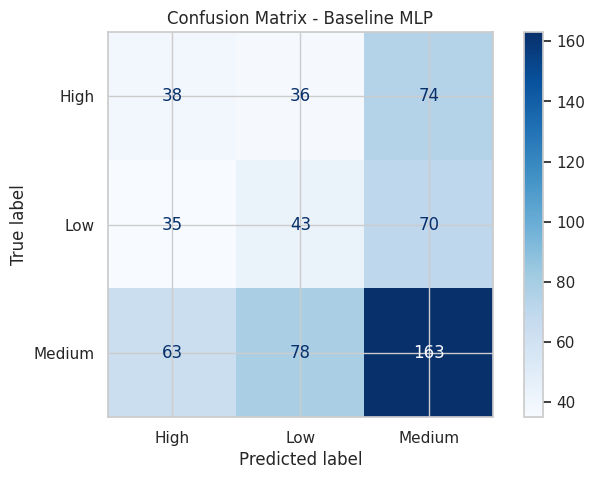

In [17]:
labels_sorted = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred_baseline, labels=labels_sorted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)

plt.figure()
disp.plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline MLP')
plt.show()

In [18]:
depth_options = [1, 2, 3]
width_options = [16, 64, 128]

results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for depth in depth_options:
    for width in width_options:
        layers = tuple([width] * depth)
        mlp = MLPClassifier(
            hidden_layer_sizes=layers,
            activation='relu',
            solver='adam',
            learning_rate_init=0.001,
            max_iter=300,
            random_state=42
        )

        model = Pipeline(steps=[
            ('preprocess', preprocess),
            ('mlp', mlp)
        ])

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring='accuracy'
        )

        results.append({
            'depth': depth,
            'width': width,
            'mean_accuracy': scores.mean(),
            'std_accuracy': scores.std()
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by='mean_accuracy', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

,depth,width,mean_accuracy,std_accuracy
0,1,16,0.448750,0.009736
3,2,16,0.432500,0.019659
6,3,16,0.414167,0.025934
2,1,128,0.404583,0.016843
7,3,64,0.402500,0.012870
1,1,64,0.396667,0.015568
5,2,128,0.389167,0.010977
8,3,128,0.379583,0.015161
4,2,64,0.369583,0.021594


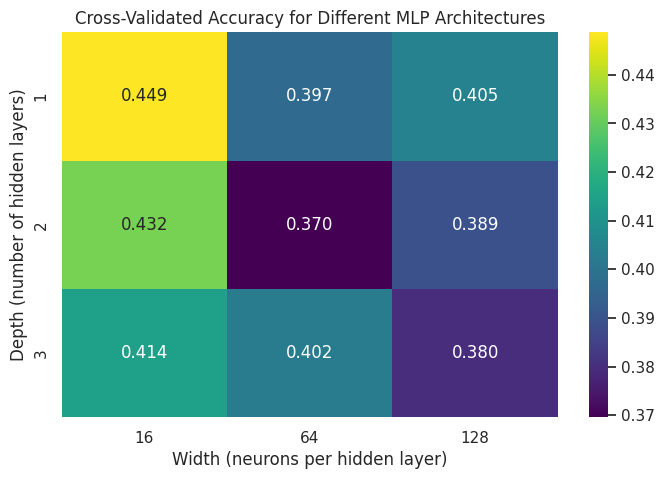

In [19]:
pivot = results_df.pivot(index='depth', columns='width', values='mean_accuracy')

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis')
plt.title('Cross-Validated Accuracy for Different MLP Architectures')
plt.xlabel('Width (neurons per hidden layer)')
plt.ylabel('Depth (number of hidden layers)')
plt.show()

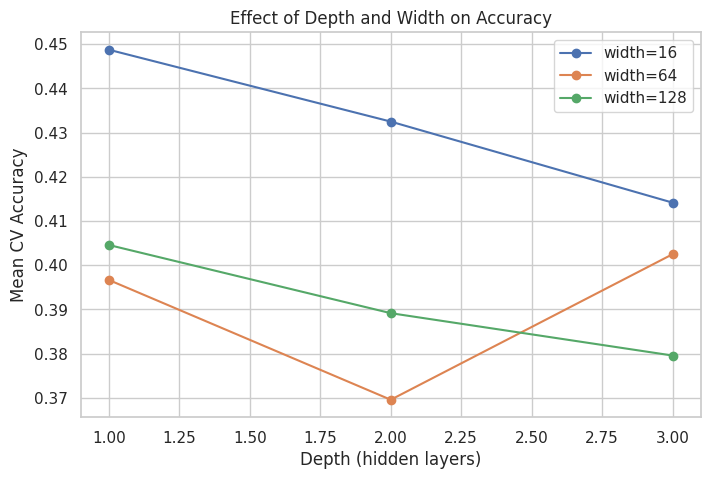

In [20]:
plt.figure()
for width in width_options:
    subset = results_df[results_df['width'] == width].sort_values('depth')
    plt.plot(
        subset['depth'],
        subset['mean_accuracy'],
        marker='o',
        label=f'width={width}'
    )

plt.title('Effect of Depth and Width on Accuracy')
plt.xlabel('Depth (hidden layers)')
plt.ylabel('Mean CV Accuracy')
plt.legend()
plt.show()

Best depth: 1
Best width: 16
Best hidden_layer_sizes: (16,)
Best MLP Test Accuracy: 0.4483

Classification Report (Best Model):
              precision    recall  f1-score   support

        High       0.22      0.09      0.13       148
         Low       0.29      0.09      0.14       148
      Medium       0.49      0.79      0.61       304

    accuracy                           0.45       600
   macro avg       0.33      0.33      0.29       600
weighted avg       0.38      0.45      0.38       600



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 800x500 with 0 Axes>

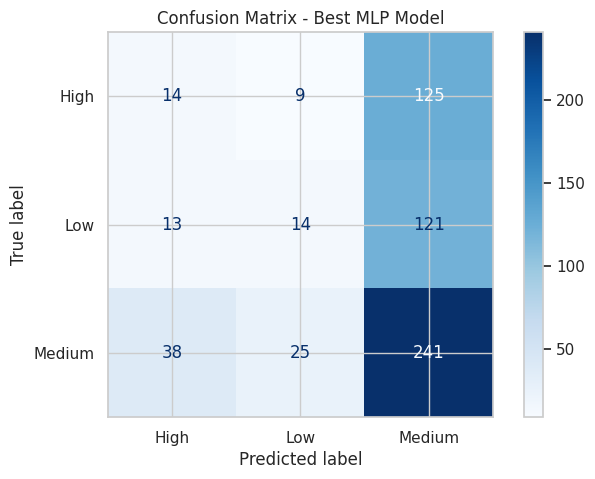

In [21]:
best_row = results_df.sort_values('mean_accuracy', ascending=False).iloc[0]
best_depth = int(best_row['depth'])
best_width = int(best_row['width'])
best_layers = tuple([best_width] * best_depth)

print('Best depth:', best_depth)
print('Best width:', best_width)
print('Best hidden_layer_sizes:', best_layers)

best_mlp = MLPClassifier(
    hidden_layer_sizes=best_layers,
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=300,
    random_state=42
)

best_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('mlp', best_mlp)
])

best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
best_acc = accuracy_score(y_test, y_pred_best)
print(f'Best MLP Test Accuracy: {best_acc:.4f}')
print('\nClassification Report (Best Model):')
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=labels_sorted)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=labels_sorted)

plt.figure()
disp_best.plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - Best MLP Model')
plt.show()

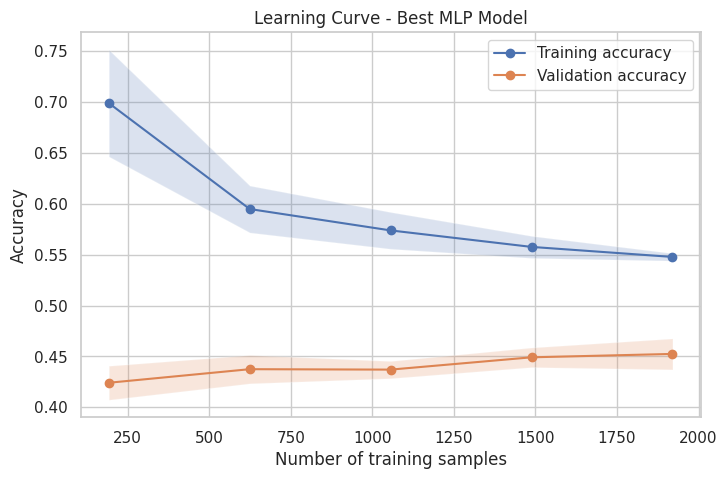

In [22]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker='o', label='Validation accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve - Best MLP Model')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

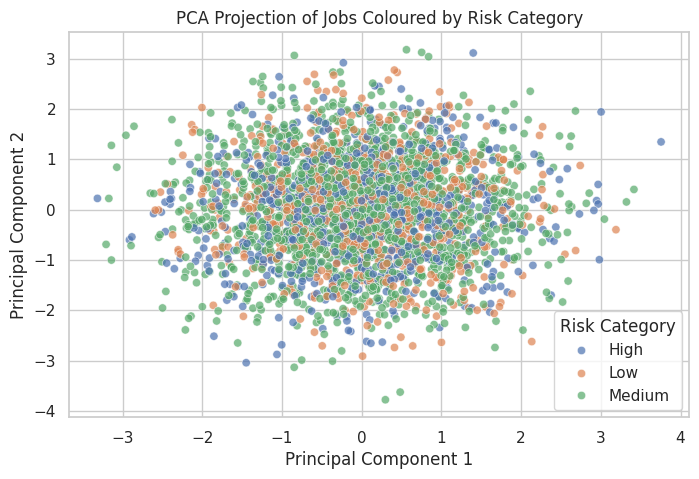

In [23]:
# PCA visualisation of preprocessed features
X_processed = preprocess.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Risk_Category': y.values
})

plt.figure()
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Risk_Category',
    alpha=0.7
)
plt.title('PCA Projection of Jobs Coloured by Risk Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Risk Category')
plt.show()